<a href="https://colab.research.google.com/github/twelvesense/first-repository/blob/master/ExplNode17.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**프로젝트: Movielens 영화 SBR**

#1: 기본 환경 구축

##1.1: 모듈

In [11]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from pathlib import Path
import os
import warnings
warnings.filterwarnings('ignore')

##1.2: 데이터

In [12]:
# 디렉토리
from google.colab import drive
drive.mount('/content/drive')
colab_dir = '/content/drive/MyDrive/colab/ExplNode17'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
data_path = Path(colab_dir + '/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬

In [57]:
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


# 2: 데이터의 전처리

##2.1: 유저 수(세션 수)와 아이템 수

In [58]:
# 유저 수(세션 수)와 아이템 수 확인
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

## 2.2: Session Length

In [59]:
# UserId를 SessionId로 해석하고, 각 세션별 클릭 데이터를 분석
session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [61]:
# session length의 median값 session length으ㅢ .mean값
session_length.median(), session_length.mean()

(96.0, 165.5975165562914)

In [62]:
# session length의 min값, session length의 max값
session_length.min(), session_length.max()

(20, 2314)

In [63]:
# session length의 quantile(0.999): 분위수(99.9%)
session_length.quantile(0.999)

1343.181000000005

In [80]:
# 길이가 100인 세션은 뭔가 이상할 수 있어, 그 중 하나를 파악
long_session = session_length[session_length==100].index[0]
data[data['UserId']==long_session]

,UserId,ItemId,Rating,Time
5428,38,587,4,978044341
5479,38,3072,4,978044383
5467,38,356,4,978044437
5516,38,490,2,978044437
5498,38,531,3,978044473
...,...,...,...,...
5452,38,13,3,978046407
5490,38,455,3,978046465
5464,38,1380,4,978046582
5433,38,3948,4,978046603


In [66]:
# 세션 길이 기준 하위 99.9%까지의 분포 누적합을 시각화한 것
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

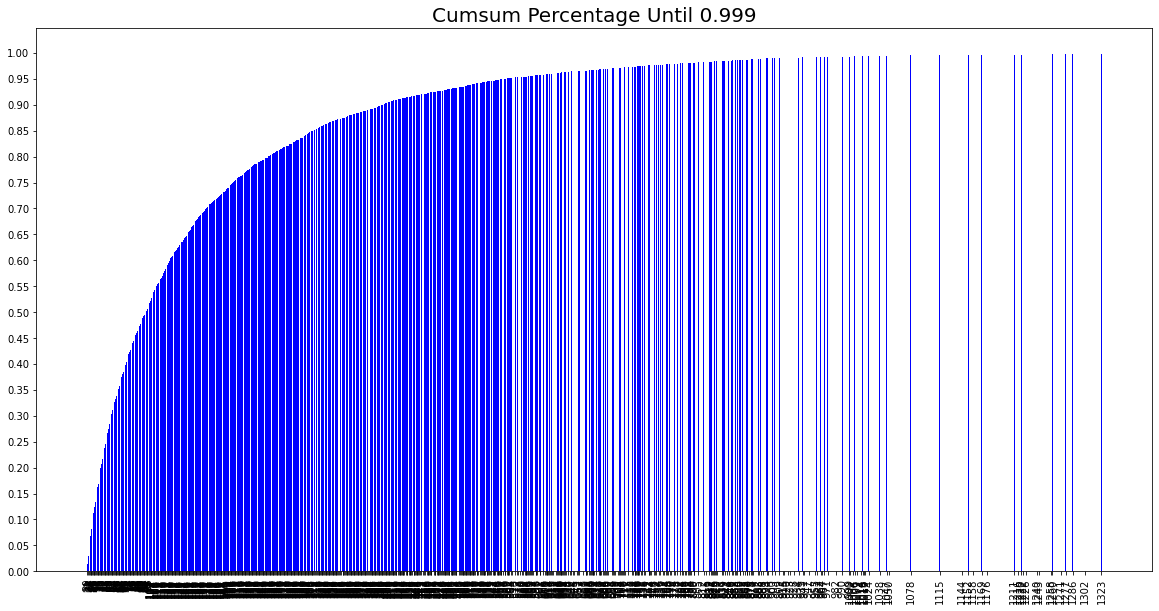

In [77]:
plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='blue')
plt.xticks(length_percent_cumsum_999.index, fontsize=10, rotation = 90)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

##2.3: Session Time

In [105]:
# time의 표현 방식 변경하기
data['Time'] = data['Time'].apply(dt.datetime.fromtimestamp)

In [106]:
# 데이터의 시간 관련 정보 파악
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest)
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


In [113]:
# 최근 1년 기준으로 제한
year_ago = latest - dt.timedelta(365)     # 최종 날짜로부터 1년 이전 날짜 구함  
data1 = data[data['Time'] > year_ago]      # 최근 1년 내 데이터만 모음
data1

,UserId,ItemId,Rating,Time
5170,36,1387,5,2002-03-12 03:46:59
5267,36,1201,4,2002-03-12 03:46:59
5122,36,1291,5,2002-03-12 03:47:16
5123,36,2167,5,2002-03-12 03:48:25
5290,36,2951,4,2002-03-12 03:48:25
...,...,...,...,...
992358,5996,3835,3,2002-04-29 20:46:24
992279,5996,2422,3,2002-04-29 20:47:05
992702,5996,168,3,2002-09-03 13:12:26
992459,5996,339,4,2002-10-07 13:24:39


## 2.4: Data Cleansing

In [108]:
# short_session을 제거한 다음 unpopular item을 제거하고, 
# 다시 길이가 1인 session이 생길 수 있어, 반복문을 통해 지속적으로 제거

def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data

def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [117]:
# data cleansing; Each user has at least 20 ratings
data1 = cleanse_recursive(data1, shortest=4, least_click=20)
data1

,UserId,ItemId,Rating,Time
5170,36,1387,5,2002-03-12 03:46:59
5122,36,1291,5,2002-03-12 03:47:16
5359,36,2115,5,2002-03-12 03:48:25
5280,36,3174,4,2002-12-22 08:11:25
5222,36,296,5,2002-12-22 08:16:59
...,...,...,...,...
992203,5996,3791,3,2002-04-29 19:58:39
992571,5996,3247,4,2002-04-29 20:05:17
992355,5996,3826,1,2002-04-29 20:10:17
992583,5996,2616,3,2002-04-29 20:16:15


## 2.5: Train / Valid / Test split

In [118]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('UserId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['UserId'].isin(session_in_train)]
    after_date = data[data['UserId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [119]:
# 가장 마지막 1일 기간 동안을 Test로, 2일 전부터 1일 전 까지를 valid set으로 나눔
tr, test = split_by_date(data1, n_days=1)
tr, val = split_by_date(tr, n_days=1)

In [122]:
# data에 대한 정보를 살펴보기
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [123]:
# tr, val, test에 대한 정보를 살펴보기
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 5594
	 Sessions: 322
	 Items: 217
	 First Time : 2002-02-28 19:06:39
	 Last Time : 2003-02-24 19:35:37

* valid Set Stats Info
	 Events: 81
	 Sessions: 3
	 Items: 72
	 First Time : 2002-03-12 21:07:55
	 Last Time : 2003-02-26 16:17:34

* test Set Stats Info
	 Events: 60
	 Sessions: 4
	 Items: 53
	 First Time : 2002-03-27 00:54:30
	 Last Time : 2003-02-27 23:31:15



In [124]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줌
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [125]:
# 데이터를 저장
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

# 3: 미니 배치의 구성

## 3.1: SessionDataset

In [128]:
# SessionDataset
class SessionDataset:
    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [129]:
# train데이터로 SessionDataset 객체를 만들고 인스턴스 변수들을 살펴보기
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
5170,36,1387,5,2002-03-12 03:46:59,0
5122,36,1291,5,2002-03-12 03:47:16,1
5359,36,2115,5,2002-03-12 03:48:25,2
5280,36,3174,4,2002-12-22 08:11:25,3
5222,36,296,5,2002-12-22 08:16:59,4
5062,36,1266,5,2002-12-22 08:18:29,5
5076,36,595,4,2002-12-22 08:18:29,6
8704,59,2997,4,2003-01-07 18:02:48,7
8797,59,3408,4,2003-01-07 18:04:52,8
8808,59,2712,3,2003-01-07 18:04:52,9


In [130]:
# tr_dataset.click_offsets
tr_dataset.click_offsets

array([   0,    7,   47,   53,   89,  106,  115,  121,  125,  143,  169,
        177,  206,  223,  259,  287,  295,  309,  313,  345,  379,  470,
        485,  490,  529,  535,  604,  613,  654,  666,  674,  679,  687,
        703,  727,  759,  763,  769,  817,  822,  851,  876,  880,  926,
        930,  944,  948,  958,  973,  994, 1016, 1029, 1034, 1088, 1110,
       1125, 1140, 1172, 1187, 1192, 1200, 1233, 1241, 1367, 1371, 1384,
       1391, 1397, 1415, 1424, 1429, 1435, 1455, 1471, 1494, 1499, 1507,
       1522, 1530, 1544, 1577, 1594, 1605, 1626, 1659, 1672, 1689, 1699,
       1707, 1712, 1717, 1742, 1751, 1757, 1769, 1784, 1799, 1805, 1843,
       1856, 1920, 1929, 1935, 1950, 1974, 1987, 2035, 2053, 2099, 2123,
       2137, 2155, 2163, 2173, 2193, 2203, 2213, 2237, 2260, 2270, 2277,
       2284, 2299, 2304, 2313, 2319, 2324, 2342, 2356, 2386, 2390, 2404,
       2417, 2425, 2429, 2435, 2444, 2457, 2490, 2509, 2517, 2547, 2553,
       2564, 2570, 2597, 2613, 2648, 2669, 2704, 27

In [131]:
# tr_dataset.session_idx
tr_dataset.session_idx

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

## 3.2: SessionDataLoader

In [132]:
# SessionDataLoader
class SessionDataLoader:
    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인
        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [133]:
# SessionDataLoader 데이터 확인
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
5170,36,1387,5,2002-03-12 03:46:59,0
5122,36,1291,5,2002-03-12 03:47:16,1
5359,36,2115,5,2002-03-12 03:48:25,2
5280,36,3174,4,2002-12-22 08:11:25,3
5222,36,296,5,2002-12-22 08:16:59,4
5062,36,1266,5,2002-12-22 08:18:29,5
5076,36,595,4,2002-12-22 08:18:29,6
8704,59,2997,4,2003-01-07 18:02:48,7
8797,59,3408,4,2003-01-07 18:04:52,8
8808,59,2712,3,2003-01-07 18:04:52,9


In [134]:
iter_ex = iter(tr_data_loader)

In [135]:
# input, output, mask 확인
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0  7 46 51]
Label Item Idx are :       [ 1  8 47 52]
Previous Masked Input Idx are []


# 4: 모델 구성

## 4.1: Evaluation Metric

In [136]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0

def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

## 4.2: Model Architecture

In [137]:
# model 생성
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [139]:
# hyper-parameter
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=2048, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

In [140]:
# model 생성
model = create_model(args)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(2048, 1, 217)]          0         
                                                                 
 GRU (GRU)                   [(2048, 50),              40350     
                              (2048, 50)]                        
                                                                 
 dropout_1 (Dropout)         (2048, 50)                0         
                                                                 
 dense_1 (Dense)             (2048, 217)               11067     
                                                                 
Total params: 51,417
Trainable params: 51,417
Non-trainable params: 0
_________________________________________________________________


# 5: 모델 학습

In [144]:
# train 셋으로 학습하면서 valid 셋으로 검증
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [ ]:
# 학습
train_model(model, args)

# 6: 모델 테스트

In [ ]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

In [ ]:
test_model(model, args, test)

#회고

* Session-Parallel Mini-Batch의 개념에 따라, 학습 속도의 저하가 최소화될 수 있도록 구성합니다.
